In [1]:
from math import sqrt, cos, sin, acos, pi, atan2
from matplotlib import cm
from matplotlib import patches
from matplotlib.colors import LogNorm
from matplotlib.path import Path
from mpl_toolkits.mplot3d import Axes3D
from numba import complex128,float64,int64,jit
import matplotlib.pyplot as plt
import numpy as np
import quadpy

#custom module
from fieldplot import GetFlow3D
from nanoscale_test import fieldplot2, rotateAroundX, rotateAroundY, rotateAroundZ, angle2D
from scattnlay import fieldnlay
from scattnlay import scattnlay

import nanoscale_test
import scattnlay

In [2]:
import pyfde

In [9]:
def fitness(p):
    x, y = p[0], p[1]
    val = 20 + (x**2 - 10*cos(2*pi*x)) + (y**2 - 10*cos(2*pi*y))
    return -val

solver = pyfde.JADE(fitness, n_dim=2, n_pop=40, limits=[(-5.12, 5.12), (-2.5, 2.5)])
#solver = pyfde.ClassicDE(fitness, n_dim=2, n_pop=40, limits=[(-5.12, 5.12), (-2.5, 2.5)])
#solver.cr, solver.f = 0.9, 0.45

best, fit = solver.run(n_it=150)

print("**Best solution found**")
print("x, y    = {:.2f}, {:.2f} (expected: 0.00, 0.00)".format(best[0], best[1]))
print("Fitness = {:.2f}".format(fit))

**Best solution found**
x, y    = -0.00, 0.00 (expected: 0.00, 0.00)
Fitness = -0.00


In [2]:
#import os
#print(os.environ['PIP_DEFAULT_TIMEOUT'])

In [2]:
import random
from deap import base, creator, tools

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

def createIndividual():
    x1 = random.randint(0, 60)
    x2 = random.randint(30, 60)
    # 3..6 + 0..0.4j
    m1 = random.uniform(3, 6)
    m1j = random.uniform(0, 0.4)
    
    # 3..6 + 0..0.4j
    m2 = random.uniform(3, 6)
    m2j = random.uniform(0, 0.4)
    
    r = np.random.rand() * x1*factor + 1
    return [x1, x2, m1, m1j, m2, m2j, r]

toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, createIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [3]:
%run kostin_kod.py

In [7]:
def evaluate(ind, layers=2, quad_n=31):
    assert len(ind)==layers*3+1
    
    r = ind[-1]
    x = ind[:layers]
    m_ = ind[layers:3*layers][::2]
    m_j = ind[layers:3*layers][1::2]
    m = map(lambda t: t[0]+t[1]*1j, zip(m_, m_j))
    
    #print("x before is {}, m is {}, r is {}".format(x, m, r))
    
    m = [z for _,z in sorted(zip(x,m), key=lambda pair: pair[0])]
    x = sorted(x)
    
    m = np.array(m)
    x = np.array(x)
        
    #if r > x[-1]*factor:
    #    r = x[-1]*factor
    
    #print("x after is {}, m is {}, r is {}".format(x, m, r))
    
    coords = get_points('quad', r=r, quad_n=quad_n)
    Iprj = integrand(coords, x, m)
    Ptot = quadpy.sphere.integrate(lambda coords: integrand(coords, x, m),
                            [0.0, 0.0, 0.0], r,
                            quadpy.sphere.Lebedev(str(quad_n))) / (4. * np.pi * r**2)
    return (3./4.*np.max(Iprj)/Ptot,)

def evaluate1l(ind):
    x1, m1, m1j, r = ind

    if r > x1*factor:
        r = x1*factor
    
    x, m = np.array([x1]), np.array([m1+m1j*1j])

    quad_n = 31
    coords = get_points('quad', r=r, quad_n=quad_n)
    Iprj = integrand(coords, x, m)
    Ptot = quadpy.sphere.integrate(lambda coords: integrand(coords, x, m),
                            [0.0, 0.0, 0.0], r,
                            quadpy.sphere.Lebedev(str(quad_n))) / (4. * np.pi * r**2)
    return (3./4.*np.max(Iprj)/Ptot,)

def get_mutate_func(all_mut_pb):
    def mutate(ind):
        new_ind = createIndividual()

        if random.random() < all_mut_pb:
            k = len(ind)
        else:
            k = 1

        for i in random.sample(range(len(ind)), k):
            ind[i] = new_ind[i]

        return ind
    return mutate

def update_fitnesses(population):
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

In [13]:
def one_plus_one(evaluate_func, mutate_func, max_plato_time=100, log=False):
    toolbox.register("evaluate", evaluate_func)
    toolbox.register("select", tools.selBest, k=1)
    toolbox.register("mutate", mutate_func)
    
    best = toolbox.individual()
    update_fitnesses([best])
    
    time_on_plato = 0
    gen = 0
    while True:
        applicant = toolbox.clone(best)
        applicant = toolbox.mutate(applicant)
        
        update_fitnesses([applicant])

        new_best = toolbox.select([best, applicant])[0]
        
        if log:
            print("Gen {}: best: {}, applicant: {}, new_best: {}".format(gen, best[0], applicant[0], new_best[0]))
        
        if new_best == best:
            time_on_plato += 1
            if time_on_plato == max_plato_time:
                break
        best = new_best
        gen += 1
        
    return best, best.fitness.values

In [16]:
from tqdm import tqdm_notebook as tqdm

MEASUREMENTS = 5

for i in tqdm(range(MEASUREMENTS)):
    print(one_plus_one(evaluate, get_mutate_func(all_mut_pb=1.0), max_plato_time=100))

for i in tqdm(range(MEASUREMENTS)):
    print(one_plus_one(evaluate, get_mutate_func(all_mut_pb=1./5), max_plato_time=100))

([42, 60, (5.193491018118219+0.3801329829309201j), (5.694498113916325+0.14227918265677855j), 33.795357917956736], (3.345726862484773,))
([47, 35, (4.160677958978269+0.31494538249994614j), (3.3035987094205033+0.33928736657612274j), 42.920609102822056], (1.3167638194369082,))
([27, 56, (4.886579036437711+0.016784600384977734j), (5.91780623933467+0.2495223741391691j), 19.940701768545164], (1.9096091674238544,))
([26, 47, (5.892819263047642+0.23999833639998674j), (3.6837663805959684+0.380087721928325j), 3.7199315675422366], (1.7754675566831917,))
([22, 53, (4.256598260286507+0.3270852887183312j), (5.146241437094205+0.18678826856330133j), 20.500008085769263], (1.9236951651154055,))



([20, 42, (3.7272313121919702+0.3359873849160102j), (3.5445390304164146+0.16049393888728056j), 7.958856944579818], (1.5059542258374001,))
([48, 36, (4.860331678678112+0.2987259082380672j), (4.291100937683683+0.21964254346974366j), 24.46072741189308], (1.5155524162799874,))
([2, 46, (5.85717923302059+0.12619897644059833j), (4.067309093820495+0.2265784254858148j), 3.2088027543333286], (1.6256586287447705,))
([15, 39, (5.359425243406388+0.39483898193546857j), (5.923101456124534+0.136063394382701j), 10.709934437301335], (1.5325101679344075,))
([43, 36, (3.1614804005505857+0.25197420874304055j), (4.435658054268402+0.3162526588315353j), 42.133596237669835], (1.3481883104747956,))



In [18]:
max_ = 0
while True:
    cur = one_plus_one(evaluate, get_mutate_func(all_mut_pb=1.0), max_plato_time=100)
    if cur[1][0] > max_:
        max_ = cur[1][0]
        print(cur)

([58, 41, (4.777098447954655+0.15852350925550676j), (5.018391368707941+0.14676568072730967j), 5.663469828341954], (1.6949045799664877,))
([22, 60, (5.209714148773305+0.2641882638007249j), (3.442269178871925+0.3269494459136125j), 11.662250838930625], (2.081202028826239,))
([3, 41, (5.421975243140012+0.01618483166293947j), (5.25551488152453+0.38378704548846687j), 4.288506068922728], (2.451275555328029,))
([58, 57, (3.880687910339916+0.27083532293943463j), (5.149118941463632+0.147993580632027j), 75.84334033817193], (4.478522594770958,))
([29, 58, (4.490520058810839+0.13631732108172434j), (5.4807738391909275+0.0847377276058337j), 30.752832721931927], (6.223880263750243,))
([27, 59, (3.4253846052455237+0.35493982296832044j), (5.420743566199322+0.026835830451027356j), 22.77427542429691], (6.739655644711596,))


KeyboardInterrupt: 

In [5]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [6]:
def genetic(evaluate_func, mutate_func, ind_func, generations=300, cxpb=0.5, mutpb=.2, popsize=20, elitesize=2, log=False):
    toolbox.register("individual", tools.initIterate, creator.Individual, ind_func)
    #toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    
    toolbox.register("evaluate", evaluate_func)
    toolbox.register("mutate", mutate_func)
    toolbox.register("mate", tools.cxTwoPoint)
    #toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("select", tools.selBest)
    
    pop = [toolbox.individual() for _ in range(popsize)]
    update_fitnesses(pop)
    
    logbook = tools.Logbook()
    
    for gen in range(generations):
        #offspring = toolbox.select(pop, len(pop))
        #offspring = map(toolbox.clone, offspring)
        offspring = map(toolbox.clone, pop)
        
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)
        if log:
            print("Gen {}: best: {}".format(gen, record['max']))
        
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cxpb:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
        
        for mutant in offspring:
            if random.random() < mutpb:
                toolbox.mutate(mutant)
                del mutant.fitness.values
                
        update_fitnesses(offspring)
        
        pop[:] = toolbox.select(offspring, k=popsize-elitesize)+toolbox.select(pop, k=elitesize)
        
    return pop, logbook

In [58]:
%%time
pop1, logbook1 = genetic(evaluate, get_mutate_func(.0), createIndividual, popsize=20, generations=300, log=False)
#pop2, logbook2 = genetic(evaluate, get_mutate_func(.0), createIndividual, popsize=30, elitesize=3, generations=500, log=False)
#pop3, logbook3 = genetic(evaluate, get_mutate_func(.1), createIndividual, popsize=20, generations=500, log=False)

CPU times: user 1min 6s, sys: 183 ms, total: 1min 6s
Wall time: 1min 6s


In [100]:
evaluate(pop1[0])

(8.083561327619819,)

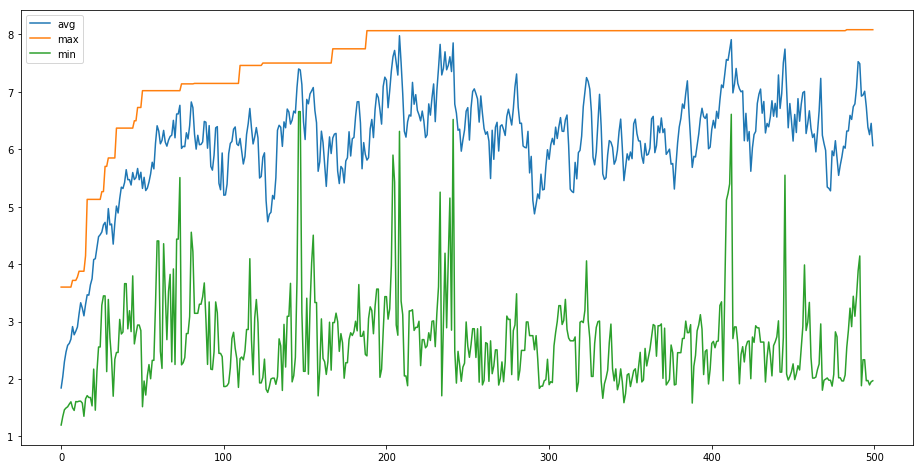

In [59]:
from_ = 0
gen = logbook1.select("gen")[from_:]
avgs = logbook1.select("avg")[from_:]
maxs = logbook1.select("max")[from_:]
mins = logbook1.select("min")[from_:]

plt.figure(figsize=(16,8))
plt.plot(gen, avgs, label='avg')
plt.plot(gen, maxs, label='max')
plt.plot(gen, mins, label='min')
plt.legend();

In [14]:
from scipy.optimize import differential_evolution

In [18]:
%%time

r1=120
r2=120

result = differential_evolution(lambda t: -evaluate(t)[0], [(3, r1), (30, r2), (3, 10), (0, 0.4), (3, 10), (0, 0.4),
                                           (0, r2*factor)],
                               popsize=5, maxiter=1000)
print(result)

     fun: -11.49542840452911
     jac: array([ 1.37596601e-03, -3.44613227e-05, -2.06696882e-03,  6.21724894e-06,
       -1.94866345e-04,  2.65228266e+00,  1.12212462e-03])
 message: 'Optimization terminated successfully.'
    nfev: 4251
     nit: 104
 success: True
       x: array([1.18482858e+02, 7.59550723e+01, 4.29136004e+00, 3.44538149e-02,
       3.25823614e+00, 0.00000000e+00, 1.00958837e+02])
CPU times: user 49.3 s, sys: 116 ms, total: 49.5 s
Wall time: 49.5 s


In [96]:
%%time

r1=120
r2=120

limits = [(10, r1), (30, r2), (3, 10), (0, 0.4), (3, 10), (0, 0.4), (0.1, r2*factor)]

solver = pyfde.JADE(lambda t: evaluate(t)[0], n_dim=len(limits), n_pop=5*len(limits), limits=limits)

best, fit = solver.run(n_it=300)

print("**Best solution found**")
#print("x, y    = {:.2f}, {:.2f} (expected: 0.00, 0.00)".format(best[0], best[1]))
print(best)
print("Fitness = {:.2f}".format(fit))

**Best solution found**
[ 22.27880468 113.90656144   4.56936845   0.4          9.02360562
   0.          73.30352866]
Fitness = 13.11
CPU times: user 2min 11s, sys: 406 ms, total: 2min 12s
Wall time: 2min 12s


In [29]:
best, fit = solver.run(n_it=150)

In [31]:
fit

-0.9248869196793031

In [33]:
evaluate(best) # best [3., 119.35367627, 10., 0.31941403, 9.03998798, 0.39947032, 110.99772349]

(64.0679312954077,)

In [16]:
result

     fun: -7.923547882240758
     jac: array([ 9.44933021e-04,  4.11937151e-04,  2.02060590e-04, -8.67927952e-04,
        3.97903932e-05,  1.21714043e+00,  8.53539461e-05])
 message: 'Optimization terminated successfully.'
    nfev: 5291
     nit: 144
 success: True
       x: array([107.45579947,  54.63409463,   7.33107237,   0.1078607 ,
         9.64976866,   0.        ,  31.5216548 ])

In [125]:
# 120
result

     fun: -11.508309838066642
     jac: array([-4.06785716e-04,  7.37188088e-05, -7.82200971e-03,  5.40421041e-03,
       -2.91322522e-05,  2.82402581e+00,  2.04281037e-05])
 message: 'Optimization terminated successfully.'
    nfev: 5039
     nit: 108
 success: True
       x: array([1.10305999e+02, 7.30934769e+01, 4.63961641e+00, 3.14544943e-02,
       3.52489062e+00, 0.00000000e+00, 9.42433911e+01])

In [22]:
# 90
result

     fun: -8.700200094381533
     jac: array([-0.001247  , -0.00056559, -0.00281801,  0.01210214, -0.00505658,
        0.00940226,  0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 7672
     nit: 107
 success: True
       x: array([3.56856501e+01, 6.12148004e+01, 7.28745462e+00, 8.82283648e-04,
       4.52744308e+00, 2.59795267e-02, 8.61241177e+01])

In [19]:
%%time

r1=120

result = differential_evolution(lambda t: -evaluate1l(t)[0], [(3, r1), (3, 10), (0, 0.4), (0, r1*factor)],
                               popsize=10, maxiter=1000)
print(result)

     fun: -8.605182946901385
     jac: array([-1.47219126e-02, -7.56438467e-02,  7.01755326e+01, -9.04165631e-05])
 message: 'Optimization terminated successfully.'
    nfev: 4005
     nit: 53
 success: True
       x: array([33.57493922,  9.66370297,  0.        , 11.24525838])
CPU times: user 41.9 s, sys: 143 ms, total: 42 s
Wall time: 42.1 s


In [142]:
def run_evaluation(algo, r_limits, m_limits, mj_limits, layers, quad_n=31):
    limits = [r_limits]*layers+[m_limits,mj_limits]*layers+[(0.1, r_limits[-1]*factor)]
    
    if algo == 'JADE':
        solver = pyfde.JADE(lambda t: evaluate(t, layers=layers, quad_n=quad_n)[0], 
                            n_dim=len(limits), n_pop=5*len(limits), limits=limits)
        best, fit = solver.run(n_it=300)
    else:
        raise AssertionError("Unknown algo")
        
    print("best {} for ind {}".format(fit, best))
    return best, fit

best 10.5596462381 for ind [1.19855611e+02 4.91883472e+00 2.60614623e-03 8.03517866e+01]
best 11.3412653122 for ind [1.12416428e+02 7.17876568e+01 4.53572879e+00 3.60998355e-02
 3.38657952e+00 0.00000000e+00 9.63378443e+01]
best 16.246251736 for ind [2.64947197e+01 1.20000000e+02 1.19858565e+02 9.11703649e+00
 5.16758833e-03 7.07832721e+00 0.00000000e+00 6.26888487e+00
 0.00000000e+00 4.77130936e+01]
best 15.6829216068 for ind [51.28152406 71.74216798 81.27054128 46.57142838  8.27673832  0.
  3.78043707  0.          4.16296309  0.         10.          0.
 33.77124164]
CPU times: user 10min 5s, sys: 1.58 s, total: 10min 7s
Wall time: 10min 7s


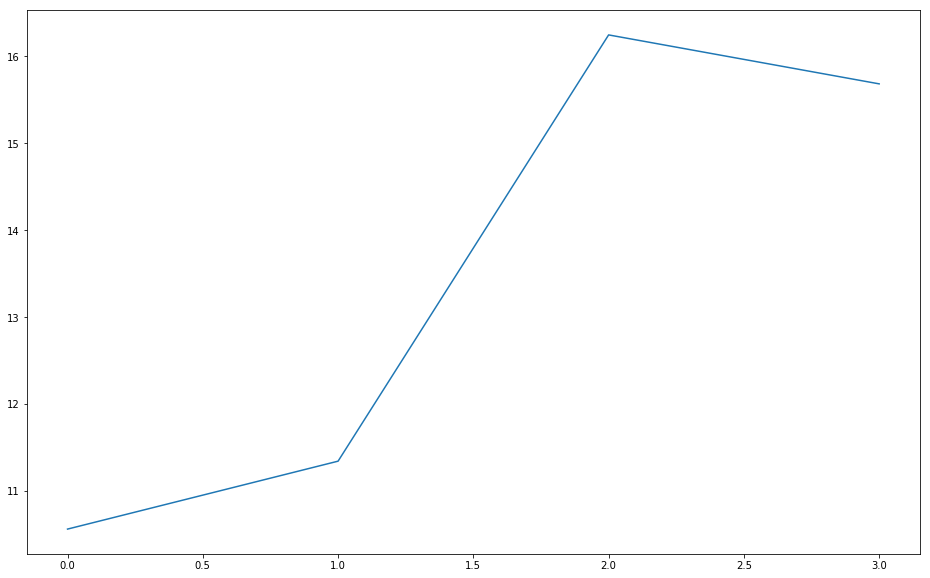

In [145]:
%%time

_, fit1 = run_evaluation('JADE', r_limits=(10,120), m_limits=(3, 10), mj_limits=(0, 0.4), layers=1)
_, fit2 = run_evaluation('JADE', r_limits=(10,120), m_limits=(3, 10), mj_limits=(0, 0.4), layers=2)
_, fit3 = run_evaluation('JADE', r_limits=(10,120), m_limits=(3, 10), mj_limits=(0, 0.4), layers=3)
_, fit4 = run_evaluation('JADE', r_limits=(10,120), m_limits=(3, 10), mj_limits=(0, 0.4), layers=4)

plt.figure(figsize=(16,10))
plt.plot([fit1, fit2, fit3, fit4])

best 9.46187410065 for ind [120.          26.33335357   4.20418922   0.           3.
   0.         120.28464706]
best 10.9267811376 for ind [5.93845152e+01 1.03112711e+02 5.16948356e+00 5.24806169e-03
 7.90945300e+00 1.83226350e-02 9.66800607e+01]
best 10.7444986724 for ind [1.20000000e+02 1.08958745e+02 5.71093293e+00 9.27417998e-03
 3.00000000e+00 8.15146916e-02 1.15833681e+02]
best 10.6613915591 for ind [120.          60.79244109   3.55197077   0.          25.82396874
   0.16843495 121.69409236]
CPU times: user 9min 16s, sys: 1.45 s, total: 9min 17s
Wall time: 9min 17s


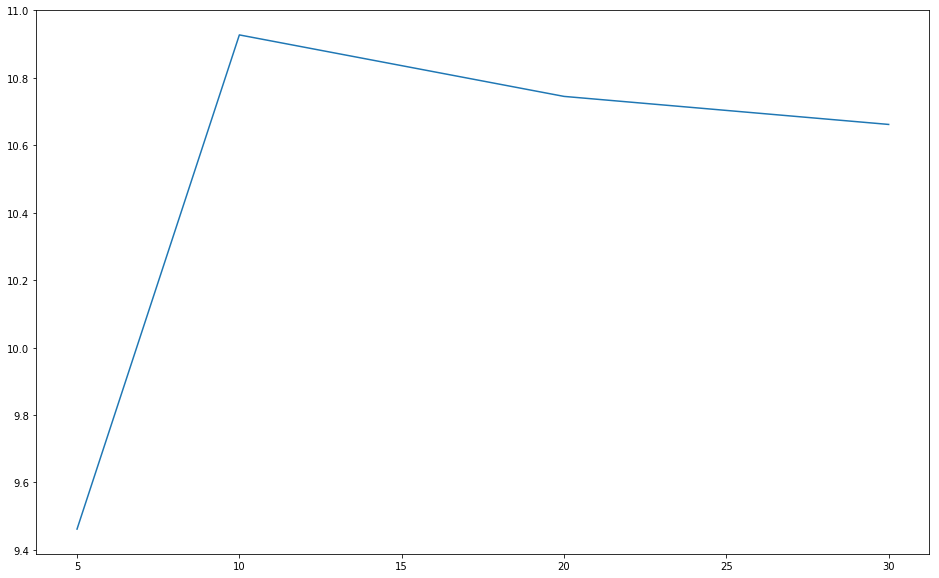

In [146]:
%%time

_, fit11 = run_evaluation('JADE', r_limits=(10,120), m_limits=(3, 5), mj_limits=(0, 0.4), layers=2)
_, fit12 = run_evaluation('JADE', r_limits=(10,120), m_limits=(3, 10), mj_limits=(0, 0.4), layers=2)
_, fit13 = run_evaluation('JADE', r_limits=(10,120), m_limits=(3, 20), mj_limits=(0, 0.4), layers=2)
_, fit14 = run_evaluation('JADE', r_limits=(10,120), m_limits=(3, 30), mj_limits=(0, 0.4), layers=2)

plt.figure(figsize=(16,10))
plt.plot([5, 10, 20, 30], [fit11, fit12, fit13, fit14])

In [147]:
%%time

run_evaluation('JADE', r_limits=(10,120), m_limits=(3, 10), mj_limits=(0, 0.4), layers=2)
run_evaluation('JADE', r_limits=(10,120), m_limits=(3, 10), mj_limits=(0, 0.0), layers=2)

best 10.9821581508 for ind [4.28319179e+01 1.18105112e+02 6.09048139e+00 0.00000000e+00
 8.50713822e+00 2.82300789e-02 5.36653699e+01]
best 12.4211485046 for ind [ 33.89536252 120.           7.25288489   0.           4.19102491
   0.          66.89342953]
CPU times: user 3min 59s, sys: 711 ms, total: 3min 59s
Wall time: 3min 59s


best 14.3085910193 for ind [119.19504254  31.14772535   4.21541638   0.           7.56763812
   0.37624847  61.42909804]
best 11.2866499992 for ind [1.19777991e+02 9.33982012e+01 4.49189003e+00 3.67270145e-02
 3.25528122e+00 2.31430992e-02 1.07128319e+02]
best 10.9276503297 for ind [5.52217930e+01 1.16903238e+02 4.64602348e+00 4.38083551e-02
 6.56355662e+00 2.12669586e-02 1.05328627e+02]
best 10.9033037951 for ind [4.44069561e+01 1.20000000e+02 3.04545435e+00 0.00000000e+00
 6.28467030e+00 1.89319488e-02 7.14825114e+01]
CPU times: user 30min 26s, sys: 1.62 s, total: 30min 28s
Wall time: 30min 28s


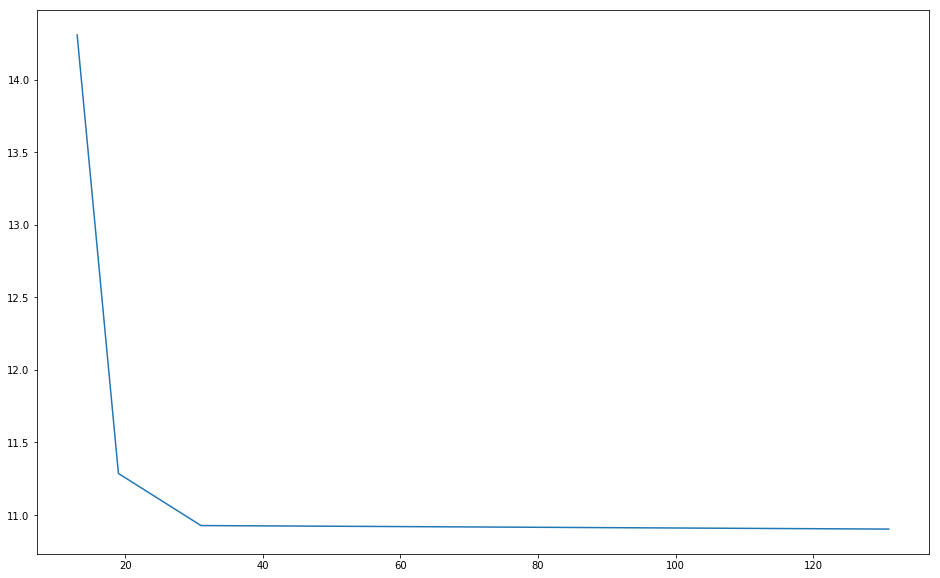

In [148]:
%%time

_, fit21 = run_evaluation('JADE', r_limits=(10,120), m_limits=(3, 10), mj_limits=(0, 0.4), layers=2, quad_n=13)
_, fit22 = run_evaluation('JADE', r_limits=(10,120), m_limits=(3, 10), mj_limits=(0, 0.4), layers=2, quad_n=19)
_, fit23 = run_evaluation('JADE', r_limits=(10,120), m_limits=(3, 10), mj_limits=(0, 0.4), layers=2, quad_n=31)
_, fit24 = run_evaluation('JADE', r_limits=(10,120), m_limits=(3, 10), mj_limits=(0, 0.4), layers=2, quad_n=131)

plt.figure(figsize=(16,10))
plt.plot([13, 19, 31, 131], [fit21, fit22, fit23, fit24])

In [149]:
%%time
best, fit = run_evaluation('JADE', r_limits=(10,120), m_limits=(3, 10), mj_limits=(0, 0.4), layers=3, quad_n=13)

best 18.0841017368 for ind [ 21.65283966 120.         118.44464843  10.           0.32880133
   3.           0.           6.33926632   0.          44.56670275]


In [50]:
#import functools
#foldl = lambda func, acc, xs: functools.reduce(func, xs, acc)

lbound = [-100., -10., -100., -100., -30., -100., -1.28, -500., -5.12, -32., -600., -50., -50.]
ubound = [100.,  10.,  100.,  100.,  30.,  100.,  1.28,  500.,  5.12,  32.,  600.,  50.,  50.]

def f_mutate_func(dim, fnum):
    def mutate(ind):
        ind[random.randint(0, dim - 1)] = random.uniform(lbound[fnum], ubound[fnum])
    return mutate

def f_create_ind_func(dim, fnum):
    def create():
        return [random.uniform(lbound[fnum], ubound[fnum]) for _ in range(dim)]
    return create

def f1(xs):
    return sum(x**2 for x in xs)
print("f1", f1([1, 2, 3]))

fs = [f1]

def test(dim, fnum, generations, popsize, elitesize):
    return genetic(lambda t: (-fs[fnum-1](t),), f_mutate_func(dim, fnum-1), f_create_ind_func(dim, fnum-1), 
                   generations, popsize=popsize, elitesize=elitesize, log=True)

('f1', 14)


In [28]:
%%time
pop, logbook = test(dim=30, fnum=1, generations=1500, popsize=100, elitesize=10)

Gen 0: best: -60909.0095783
Gen 1: best: -58306.2399319
Gen 2: best: -57652.3925104
Gen 3: best: -43259.4516961
Gen 4: best: -43259.4516961
Gen 5: best: -43259.4516961
Gen 6: best: -43259.4516961
Gen 7: best: -43259.4516961
Gen 8: best: -35106.965211
Gen 9: best: -35106.965211
Gen 10: best: -35106.965211
Gen 11: best: -34141.1213991
Gen 12: best: -29552.4056632
Gen 13: best: -28024.9563078
Gen 14: best: -24576.7787555
Gen 15: best: -24576.7787555
Gen 16: best: -23945.9858717
Gen 17: best: -23676.1576116
Gen 18: best: -23349.8539829
Gen 19: best: -21024.2730871
Gen 20: best: -18042.0817189
Gen 21: best: -18042.0817189
Gen 22: best: -18042.0817189
Gen 23: best: -16041.4356087
Gen 24: best: -15644.3888594
Gen 25: best: -14226.1235712
Gen 26: best: -14226.1235712
Gen 27: best: -14226.1235712
Gen 28: best: -13411.2718318
Gen 29: best: -12258.1318426
Gen 30: best: -12258.1318426
Gen 31: best: -9804.65876882
Gen 32: best: -9570.0978717
Gen 33: best: -9570.0978717
Gen 34: best: -9026.92581349


Gen 308: best: -192.988915869
Gen 309: best: -192.988915869
Gen 310: best: -192.988915869
Gen 311: best: -189.592744839
Gen 312: best: -189.592744839
Gen 313: best: -189.592744839
Gen 314: best: -189.592744839
Gen 315: best: -189.592744839
Gen 316: best: -189.592744839
Gen 317: best: -189.592744839
Gen 318: best: -186.557915283
Gen 319: best: -186.557915283
Gen 320: best: -186.557915283
Gen 321: best: -178.083624396
Gen 322: best: -178.083624396
Gen 323: best: -178.083624396
Gen 324: best: -178.083624396
Gen 325: best: -178.083624396
Gen 326: best: -178.083624396
Gen 327: best: -177.183682789
Gen 328: best: -177.183682789
Gen 329: best: -177.183682789
Gen 330: best: -177.183682789
Gen 331: best: -177.183682789
Gen 332: best: -146.592508298
Gen 333: best: -146.592508298
Gen 334: best: -140.582030635
Gen 335: best: -140.582030635
Gen 336: best: -140.582030635
Gen 337: best: -140.582030635
Gen 338: best: -140.582030635
Gen 339: best: -140.333251175
Gen 340: best: -140.333251175
Gen 341: b

Gen 600: best: -45.3588147865
Gen 601: best: -45.3588147865
Gen 602: best: -45.3588147865
Gen 603: best: -45.3588147865
Gen 604: best: -45.3588147865
Gen 605: best: -45.3588147865
Gen 606: best: -45.3588147865
Gen 607: best: -45.3588147865
Gen 608: best: -45.164787376
Gen 609: best: -45.164787376
Gen 610: best: -45.164787376
Gen 611: best: -45.164787376
Gen 612: best: -45.164787376
Gen 613: best: -45.164787376
Gen 614: best: -44.6631209332
Gen 615: best: -44.6631209332
Gen 616: best: -44.6631209332
Gen 617: best: -42.780635656
Gen 618: best: -42.780635656
Gen 619: best: -42.780635656
Gen 620: best: -41.9823053209
Gen 621: best: -41.9823053209
Gen 622: best: -41.7361753453
Gen 623: best: -41.7361753453
Gen 624: best: -41.7361753453
Gen 625: best: -41.7361753453
Gen 626: best: -41.7361753453
Gen 627: best: -41.576354129
Gen 628: best: -41.576354129
Gen 629: best: -41.576354129
Gen 630: best: -41.5321806628
Gen 631: best: -38.0765284554
Gen 632: best: -38.0765284554
Gen 633: best: -35.294

Gen 891: best: -5.26838388869
Gen 892: best: -5.26838388869
Gen 893: best: -5.26838388869
Gen 894: best: -5.26838388869
Gen 895: best: -5.26838388869
Gen 896: best: -5.26838388869
Gen 897: best: -5.26838388869
Gen 898: best: -5.26838388869
Gen 899: best: -5.26838388869
Gen 900: best: -5.26838388869
Gen 901: best: -5.26838388869
Gen 902: best: -5.26838388869
Gen 903: best: -5.26838388869
Gen 904: best: -5.26838388869
Gen 905: best: -5.26838388869
Gen 906: best: -5.26838388869
Gen 907: best: -5.26838388869
Gen 908: best: -5.26838388869
Gen 909: best: -5.26838388869
Gen 910: best: -5.26838388869
Gen 911: best: -5.26838388869
Gen 912: best: -5.26838388869
Gen 913: best: -5.26838388869
Gen 914: best: -5.26838388869
Gen 915: best: -5.26838388869
Gen 916: best: -5.26838388869
Gen 917: best: -5.26838388869
Gen 918: best: -5.26838388869
Gen 919: best: -5.26838388869
Gen 920: best: -5.26838388869
Gen 921: best: -5.26838388869
Gen 922: best: -5.26838388869
Gen 923: best: -5.26838388869
Gen 924: b

Gen 1171: best: -2.03950219407
Gen 1172: best: -2.03950219407
Gen 1173: best: -2.03950219407
Gen 1174: best: -2.03950219407
Gen 1175: best: -2.03950219407
Gen 1176: best: -2.03950219407
Gen 1177: best: -2.03950219407
Gen 1178: best: -2.03950219407
Gen 1179: best: -2.03950219407
Gen 1180: best: -2.03950219407
Gen 1181: best: -2.03950219407
Gen 1182: best: -2.03950219407
Gen 1183: best: -2.03950219407
Gen 1184: best: -2.03950219407
Gen 1185: best: -2.03950219407
Gen 1186: best: -2.03950219407
Gen 1187: best: -2.03950219407
Gen 1188: best: -2.03950219407
Gen 1189: best: -2.03950219407
Gen 1190: best: -2.03950219407
Gen 1191: best: -2.03950219407
Gen 1192: best: -2.03950219407
Gen 1193: best: -2.03950219407
Gen 1194: best: -2.03950219407
Gen 1195: best: -2.03950219407
Gen 1196: best: -2.03950219407
Gen 1197: best: -2.03950219407
Gen 1198: best: -2.03950219407
Gen 1199: best: -2.03950219407
Gen 1200: best: -2.03950219407
Gen 1201: best: -2.03950219407
Gen 1202: best: -2.03950219407
Gen 1203

Gen 1473: best: -1.34262326626
Gen 1474: best: -1.34262326626
Gen 1475: best: -1.34262326626
Gen 1476: best: -1.34262326626
Gen 1477: best: -1.34262326626
Gen 1478: best: -1.34262326626
Gen 1479: best: -1.34262326626
Gen 1480: best: -1.34262326626
Gen 1481: best: -1.34262326626
Gen 1482: best: -1.34262326626
Gen 1483: best: -1.34262326626
Gen 1484: best: -1.34262326626
Gen 1485: best: -1.34262326626
Gen 1486: best: -1.34262326626
Gen 1487: best: -1.34262326626
Gen 1488: best: -1.34262326626
Gen 1489: best: -1.34262326626
Gen 1490: best: -1.34262326626
Gen 1491: best: -1.34262326626
Gen 1492: best: -1.34262326626
Gen 1493: best: -1.34262326626
Gen 1494: best: -1.34262326626
Gen 1495: best: -1.34262326626
Gen 1496: best: -1.34262326626
Gen 1497: best: -1.34262326626
Gen 1498: best: -1.34262326626
Gen 1499: best: -1.34262326626


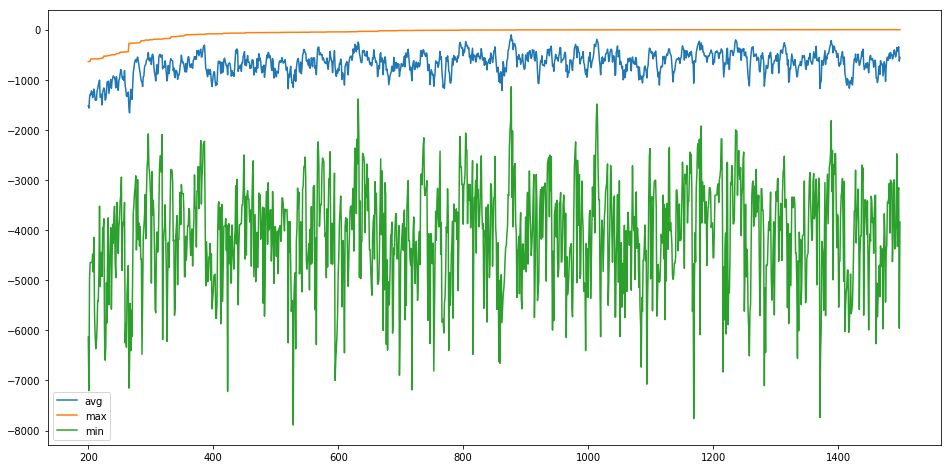

In [29]:
from_ = 200
gen = logbook.select("gen")[from_:]
avgs = logbook.select("avg")[from_:]
maxs = logbook.select("max")[from_:]
mins = logbook.select("min")[from_:]

plt.figure(figsize=(16,8))
plt.plot(gen, avgs, label='avg')
plt.plot(gen, maxs, label='max')
plt.plot(gen, mins, label='min')
plt.legend();

In [90]:
%%time
#result = differential_evolution(f1, [(lbound[0], ubound[0])]*30)
result = differential_evolution(f1, [(lbound[0], ubound[0])]*30, popsize=3, maxiter=500)

CPU times: user 1.85 s, sys: 0 ns, total: 1.85 s
Wall time: 1.85 s


In [91]:
result

     fun: 1.7078317147556825e-12
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 45121
     nit: 500
 success: False
       x: array([ 2.22037499e-07,  3.43423068e-09,  2.16933138e-07,  2.79512857e-08,
        1.91180249e-07,  1.57284918e-07, -7.16592230e-08, -5.38929779e-07,
        1.98718131e-07, -4.03675982e-07,  6.48630705e-08,  1.20286225e-07,
       -5.36683253e-08, -6.63799460e-08,  1.74237913e-07, -8.20682633e-08,
       -6.84780899e-08, -3.51917717e-07,  3.40073303e-07,  2.14891038e-07,
       -2.15325435e-07,  3.37424066e-07, -2.36356046e-07, -9.68037761e-08,
       -2.32492881e-07,  2.61899502e-07, -4.54604909e-08,  4.51895921e-07,
       -3.20782256e-07,  2.01664929e-07])

In [89]:
print("%.50f"%result.x[5])

0.00000000000000000000000000000000000000000000000000


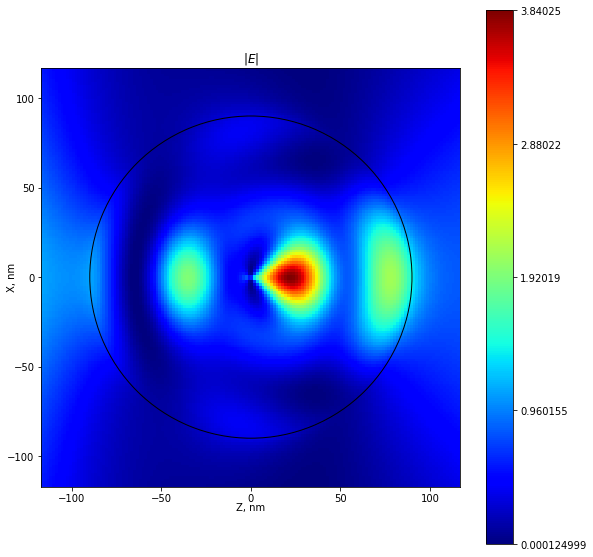

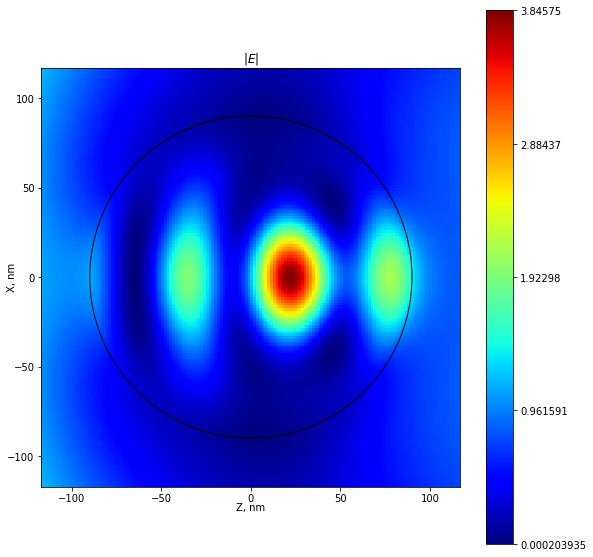

In [8]:
coords = get_points('meshXZ')
# Eamp = get_field(coords)
# Eabs = np.sqrt(Eamp[:, 0]**2 + Eamp[:, 1]**2 + Eamp[:, 2]**2)
Iprj = integrand(coords)
fieldplot2(Iprj, coords[:,0], coords[:,2], x, m, npts, factor)
#fieldplot2(Eabs, coords[:,0], coords[:,2], x, m, npts, factor)
#fieldplot2(Eamp[:,2], coords[:,0], coords[:,2], x, m, npts, factor)
plt.show()

coords = get_points('meshYZ')
Iprj = integrand(coords)
fieldplot2(Iprj, coords[:,1], coords[:,2], x, m, npts, factor)
plt.show()

CPU times: user 8.04 s, sys: 19.4 ms, total: 8.06 s
Wall time: 8.06 s


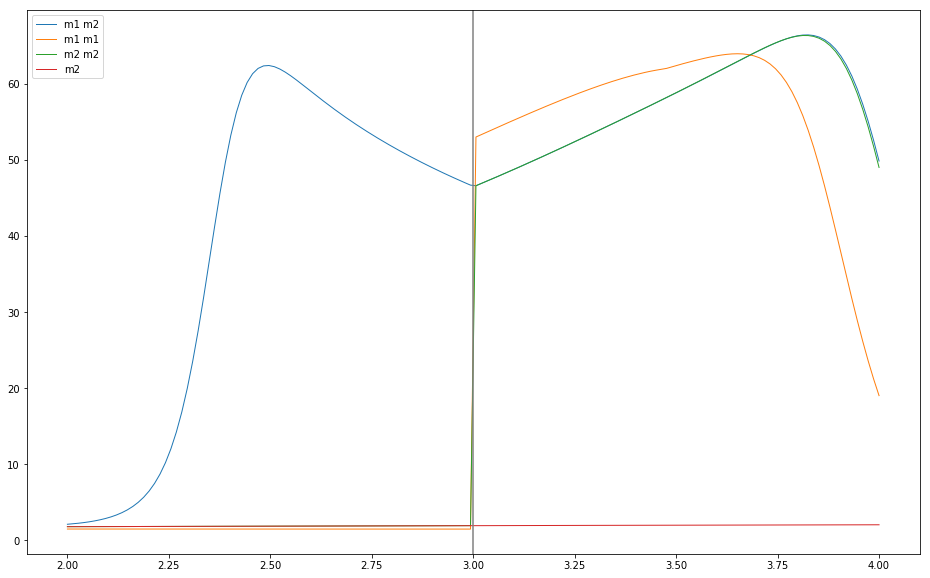

In [9]:
%%time
plt.figure(figsize=(16,10))

def draw_plot(x, m, label, R=None, lw=1, quad_n=31):
    if R is None:
        R = np.linspace(0.6, x[-1]*factor, num=300)
    D = []
    for r in R:
        coords = get_points('quad', r=r, quad_n=quad_n)
        Iprj = integrand(coords, x=x, m=m)
        Ptot = quadpy.sphere.integrate(lambda t: integrand(t, x=x, m=m),
                                [0.0, 0.0, 0.0], r,
                                quadpy.sphere.Lebedev(str(quad_n))) / (4. * np.pi * r**2)
        D.append(3./4.*np.max(Iprj)/Ptot)

    D = np.array(D)
    plt.plot(R,D,label=label,lw=lw)
    
# 3., 119.35367627, 10., 0.31941403, 9.03998798, 0.39947032 
# max is 110.99772349

x = np.array([3., 119.3536762660138350611305213533341884613037109375])

m = np.array([10.+0.3194140289291589884790312225959496572613716125j, 
              9.0399879773481472966523142531514167785644531250+0.3994703230773163915579004878964042291045188904j])
draw_plot(x, m, 'm1 m2', R=np.linspace(2., 4., num=150))
draw_plot(x, [m[0], m[0]], 'm1 m1', R=np.linspace(2., 4., num=150))
draw_plot(x, [m[1], m[1]], 'm2 m2', R=np.linspace(2., 4., num=150))
draw_plot(np.array([x[1]]), [m[1]], 'm2', R=np.linspace(2., 4., num=150))

plt.legend()
plt.axvline(x=x[0], c='gray');

In [42]:
best

array([  3.        , 119.35367627,  10.        ,   0.31941403,
         9.03998798,   0.39947032, 110.99772349])

In [81]:
evaluate(best)

x is [  3.         119.35367627], m is [10.        +0.31941403j  9.03998798+0.39947032j], r is 3.9


(64.0679312954077,)

In [87]:
evaluate([  3.        , 119.35367627,  10.        ,   0.31941403,
         9.03998798,   0.39947032, 3.9])

x is [  3.         119.35367627], m is [10.        +0.31941403j  9.03998798+0.39947032j], r is 3.9


(20.776882904313474,)

In [88]:
evaluate([3., 119.3536762660138350611305213533341884613037109375, 
          10., 0.3194140289291589884790312225959496572613716125,
         9.0399879773481472966523142531514167785644531250, 0.3994703230773163915579004878964042291045188904,
         3.9])

x is [  3.         119.35367627], m is [10.        +0.31941403j  9.03998798+0.39947032j], r is 3.9


(64.06793129540765,)

In [71]:
evaluate([3., 119.3536762660138350611305213533341884613037109375, 
          10., 0.3194140289291589884790312225959496572613716125,
         9.0399879773481472966523142531514167785644531250, 0.3994703230773163915579004878964042291045188904,
         11.0])

(64.0679312954077,)

In [174]:
print("{:.46f}".format(best[7]))

6.3392663229166519300861182273365557193756103516


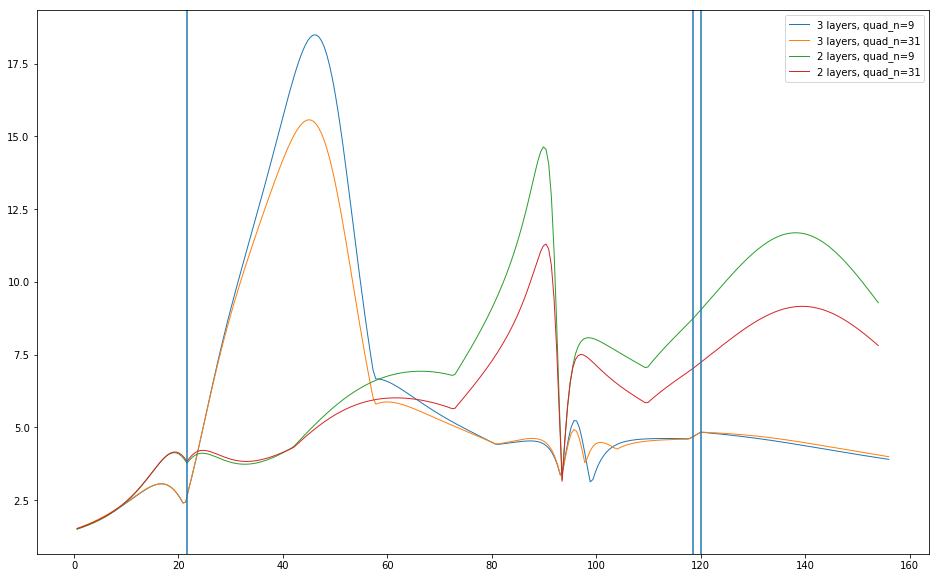

In [186]:
plt.figure(figsize=(16,10))

# 44.56670275

x = np.array([21.65283966, 118.44464843, 120.])
m = np.array([10.+0.32880133j, 6.33926632, 3.0])
draw_plot(x, m, '3 layers, quad_n=9', quad_n=9)
draw_plot(x, m, '3 layers, quad_n=31', quad_n=31)
draw_plot(x[:2], m[:2], '2 layers, quad_n=9', quad_n=9)
draw_plot(x[:2], m[:2], '2 layers, quad_n=31', quad_n=31)
plt.axvline(x[0])
plt.axvline(x[1])
plt.axvline(x[2])

plt.legend();

In [165]:
evaluate(best, layers=3, quad_n=9)

(18.233067935715543,)

In [160]:
evaluate(best, layers=3, quad_n=11)

(11.644983470439984,)

In [156]:
evaluate(best, layers=3, quad_n=31)

(15.556235617443164,)

In [155]:
evaluate(best, layers=3, quad_n=13)

(18.084101736798527,)

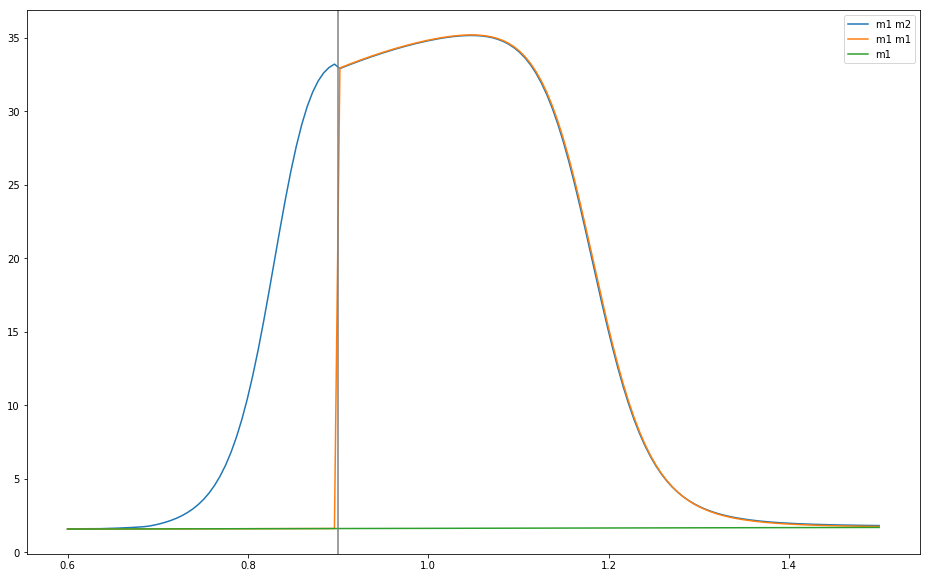

In [110]:
plt.figure(figsize=(16,10))

x = np.array([.9, 59.3])
m = np.array([3.512+0.105j, 3.557+0.094j])
draw_plot(x, m, 'm1 m2')
x = np.array([.9, 59.3])
m = np.array([3.512+0.105j, 3.512+0.105j])
draw_plot(x, m, 'm1 m1')
x = np.array([59.3])
m = np.array([3.512+0.105j])
draw_plot(x, m, 'm1')

plt.legend()
plt.axvline(x=.9, c='gray');

In [ ]:
#0.76951308, 57.74828155,  5.6565611+0.24617685j,  5.2440586+0.39699948j, 44.50551135

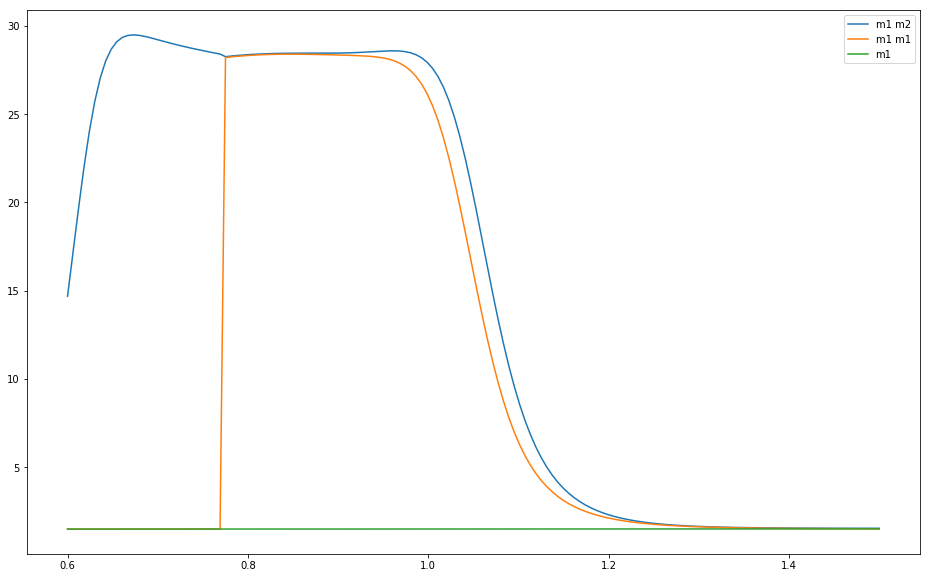

In [109]:
plt.figure(figsize=(16,10))

x = np.array([0.76951308, 57.74828155])
m = np.array([5.6565611+0.24617685j, 5.2440586+0.39699948j])
draw_plot(x, m, 'm1 m2')
m = np.array([5.6565611+0.24617685j, 5.6565611+0.24617685j])
draw_plot(x, m, 'm1 m1')
x = np.array([57.74828155])
m = np.array([5.6565611+0.24617685j])
draw_plot(x, m, 'm1')

plt.legend();

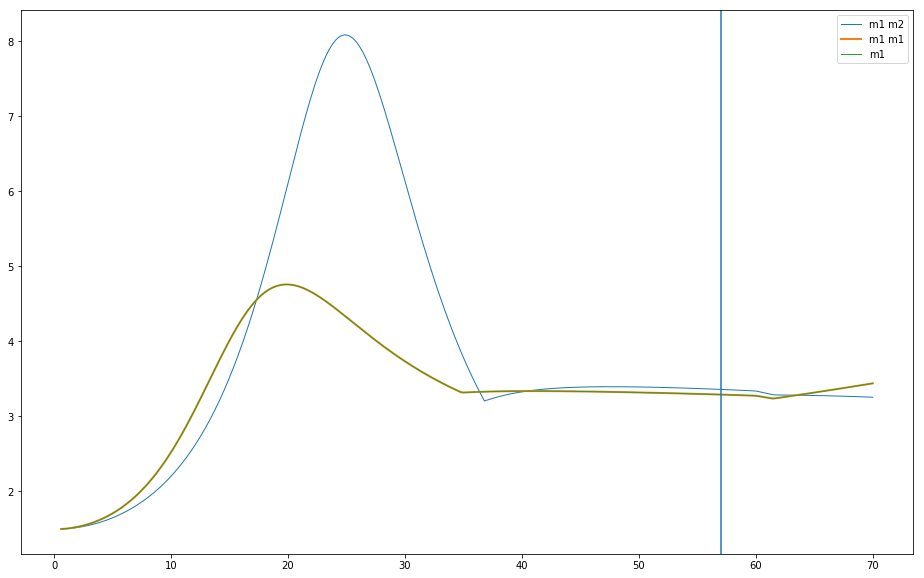

In [114]:
x1, x2, m1, m1j, m2, m2j, r = pop1[0]

plt.figure(figsize=(16,10))

x = np.array([x1, x2])
m = np.array([m1+m1j*1j, m2+m2j*1j])
draw_plot(x, m, 'm1 m2', R=np.linspace(0.6, x2+10, num=350))
m = np.array([m1+m1j*1j, m1+m1j*1j])
draw_plot(x, m, 'm1 m1', R=np.linspace(0.6, x2+10, num=350), lw=2)
x = np.array([x2])
m = np.array([m1+m1j*1j])
draw_plot(x, m, 'm1', R=np.linspace(0.6, x2+10, num=200))

plt.axvline(x=x1)
plt.legend();

In [107]:
pop1[0]

[57,
 60,
 5.353924567115667,
 0.00394500841369192,
 5.641137305252917,
 0.0003658807026354794,
 25.009245946217856]

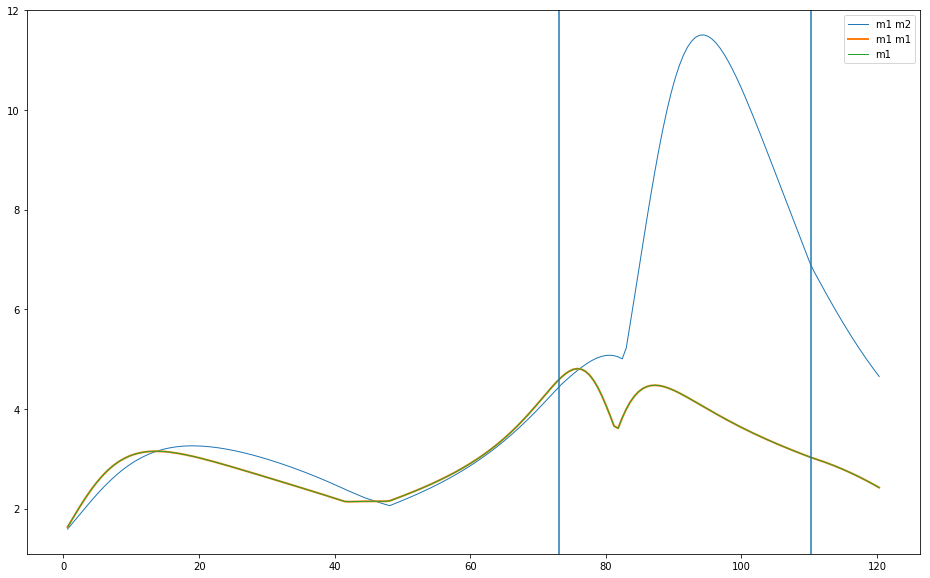

In [10]:
x1, x2, m1, m1j, m2, m2j = [7.30934769e+01, 1.10305999e+02, 3.52489062e+00, 0.00000000e+00, 4.63961641e+00, 3.14544943e-02]

plt.figure(figsize=(16,10))

x = np.array([x1, x2])
m = np.array([m1+m1j*1j, m2+m2j*1j])
draw_plot(x, m, 'm1 m2', R=np.linspace(0.6, x2+10, num=200))
m = np.array([m1+m1j*1j, m1+m1j*1j])
draw_plot(x, m, 'm1 m1', R=np.linspace(0.6, x2+10, num=200), lw=2)
x = np.array([x2])
m = np.array([m1+m1j*1j])
draw_plot(x, m, 'm1', R=np.linspace(0.6, x2+10, num=200))

plt.axvline(x=x1)
plt.axvline(x=x2)
plt.legend();